In [ ]:
# Names: Max Collins, Marwan Bit, Nikolas Hall
# Physics 24A
# Prof. Saeta
# Final Project: Gravity Assist "Slingshot" Maneuver

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver

# Constants we'll need:


SATM = 4.15049*10**(-28)   # Mass of the satellite

# SATM = 1
EARTHM = .000003003
    

fpsq = 4 * (np.pi)**2 # Four pi-squared
G =  fpsq # Gravitational constant wrong units

In [3]:
def sun_fall(t ,Y, *args):
    return Y[0]**2+Y[2]**2
sun_fall.terminal = True

In [148]:
class Planet():
    """Allows us to create objects that represent the Sun and the planets."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        #super().__init__(
         #   (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
         #    ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        #
        # Now store variables, using defaults, if necessary
        self.mass = kwargs.get('m', 1.0)        # Mass, in solar masses
        self.radius = kwargs.get('r', 0.00047)  # Planetary radius, in AU (default is for Jupiter)
        self.rorbit = kwargs.get('ro', 1.0)     # Orbital radius, in AU (assumes perfectly circular orbits)
        self.period = self.period = np.sqrt(((self.rorbit)**3) / (self.mass + 1))    # Period of orbit determined by other parameters
                                                                # In denominator, G multiplied by 1 solar mass => G
            
        self.offset = kwargs.get('off',0)
        self.ω = 0
        if self.period != 0:
            self.ω = (2* np.pi)/self.period
        
    def __str__(self):
        "Produces a string representation of the planet's parameters."
        string = "Mass: " + str(self.mass) + "  Radius: " + str(self.radius) + "  Radius of Orbit: " + str(self.rorbit) + "  Period: " + str(self.period)
        return str(string)
        # Add units, and figure out how to get each attribute onto a new line.
    
    def orbit(self, R, ω, t):
        """
        Arguments: R is the radius of orbit of a planet, ω is its angular speed, and t is the time of interest.
        Returns: Cartesian coordinates for position of the planet at time t.
        """
        return (R * np.math.cos(ω * (t+self.offset)), R * np.math.sin(ω * (t+self.offset)))
    

 # Planets for a default simulation
SUN = Planet(m = 1, r = 0.00465047, ro = 0.0)        # Figure out solar radius (AU) and Jupiter's mass (solar masses)
JUP = Planet(m = .00095, r = 0.000477895, ro = 5.2, off = 165.83976178288287)
SATURN = Planet(m = 0.000285716656, r = 0.000389256877, ro = 9.555, off = 4.485848484848484)

class Satellite(P24ASolver):
    """Allows us to define an object representing our space probe. Simulates a solar system of planets with perfectly circular orbits."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        )
        # Now store variables, using defaults, if necessary
        self.position = kwargs.get('r', [0, -1])    # Satellite's position in Cartesian coordinates
                                                    # Default is x = -1 AU y = 0 AU
            
        self.velocity = kwargs.get('v', [0, 0])     # Satellite's velocity in the x- and y-directions
                                                    # Default is satellite at rest
            
        self.planets = kwargs.get('p', [SUN, JUP])  # A list of the planets that the satellite can interact with
                                                    # By default, includes the Sun and Jupiter, SUN MUST ALWAYS BE FIRST
        self.events.append(sun_fall)
        
        self.time_offset = kwargs.get('t_off', 0)   #the time offset we need to launch at
        
        
        # We treat the satellite as though it has negligible mass and no radius
        # The satellite is a point moving through space
        
        
    def __str__(self):
        "Produces a string representation of a satellite."
        string = "Position: (x, y) = " + str(self.position) + "  Velocity: (vx, vy) = " + str(self.velocity)
        return str(string)
    

    
    def derivatives(self, t, Y):
        """ Accepts: Time of interest, derivatives vector, and """
        x1, v1, x2, v2 = Y  # Unpack the values
                            # x1 = x-position, v1 = x-velocity
                            # x2 = y-position, v2 = y-velocity
        
        
        
        numPlanets = len(self.planets)
        
        Alist = []
        
        for planet in self.planets:          # For each planet in the simulation...
            xp1, xp2 = planet.orbit(planet.rorbit, planet.ω, t)    # Get the planet's cartesian position
            
            r_sq = (x1 - xp1)**2 + (x2 - xp2)**2   # Square of the satellite's distance from the current planet
            
            x = xp1 - x1
            y = xp2 - x2
            
            cosine_theta = y/np.sqrt(r_sq)
            
            sine_theta = x/np.sqrt(r_sq)
            
            # Get the components of the satellite's gravitational acceleration due to this planet
            a1 = float((G * planet.mass) / r_sq)*sine_theta
            a2 = float((G * planet.mass) / r_sq)*cosine_theta
#             if planet.mass == 1.0:
#                 print('accel due to sun:', '(',a1,a2,')')
            # Add those components to a list of accelerations
            Alist += [[a1, a2]]
            
        A1 = 0   # Total acceleration in the x-direction
        A2 = 0   # Total acceleration in the y-direction
        
        # Sum components to get the total x- and y-accelerations
        for a in Alist:
            A1 += a[0]
            A2 += a[1]
        
        return [v1, A1, v2, A2]   # Return a time derivative of Y
    
    

    

    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize = (10, 10))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-2, 10))
        ax.set_ylim((-2, 10))

        self.shapes = [Circle(self.position, radius = .05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle(planet.orbit(planet.rorbit, planet.ω, 0), radius = planet.radius, color = 'b'))

        
        for s in self.shapes:
            ax.add_patch(s)
        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        x1, v1, x2, v2 = self.solution.sol(t)
        
        
        # First step is to remove the existing shapes
        for n in range(len(self.shapes)-1, -1, -1):
            self.shapes[n].remove()
                                
        self.shapes = [Circle((x1,x2), radius = .005, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle(planet.orbit(planet.rorbit, planet.ω, t), radius = 100*planet.radius, color = 'b'))
            
        for s in self.shapes:
            self._ax.add_patch(s)

#         title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return self.shapes

In [128]:
def hohmann(r1, r2):
    """
    returns velocity (vx,vy) for achieving a hohmann transfer from (x:0, y:-r1) to (x:0,y:r2)
    """
    
    init_vel = G*EARTHM/r1
    
    delta_E = -(G*SATM*EARTHM/2)*(1/r2-1/r1)
    
    delta_vel = (-init_vel+np.sqrt(init_vel**2+4*(2*delta_E/SATM)))/2
    
    return init_vel+delta_vel #account for the fact that this velocity should be relative to the sun


hohmann(1.33691742445368918*10**(-5), 5.2)

9.774879066995855

In [140]:
def KE(t, solution):
    """
    returns the kinetic energy of the satellite at t gives a solution
    """
    return .5*SATM*(solution(t)[1]**2+solution(t)[3]**2)

def Tot_Energy(t, solution):
    '''
    This function takes in the time and returns an expression for the energy...
    '''
    total_U = []
    
    K_sat = KE(t, solution)
    #now let's get the potential due to the sun
    sun_radius = np.sqrt(solution(t)[0]**2 + solution(t)[2]**2)
    U_sun = -G*SATM/sun_radius
    total_U.append(U_sun)
    for planet in solution.planets[1:]:
        planet_radii = np.sqrt((planet.orbit(planet.rorbit,planet.ω, t)[0] -solution(t)[0])**2+(planet.orbit(planet.rorbit,planet.ω, t)[1]-solution(t)[2])**2)
        U_planet = (-G*(planet.mass*SATM))/(planet_radii)
        total_U.append(U_planet)
        
    
    return K_sat + sum(total_U)

In [149]:
Sat = Satellite(t_off = 165.83966178288287, p = [SUN, JUP, SATURN])
rest = (0,9.77,-1,0)
sol1 = Sat.solve(rest, (0,4))
times = np.linspace(0,4,100)
#(0.04367606915377616, 6.4, 4.799999999999999, 15.035863584952462)

<IPython.core.display.Javascript object>


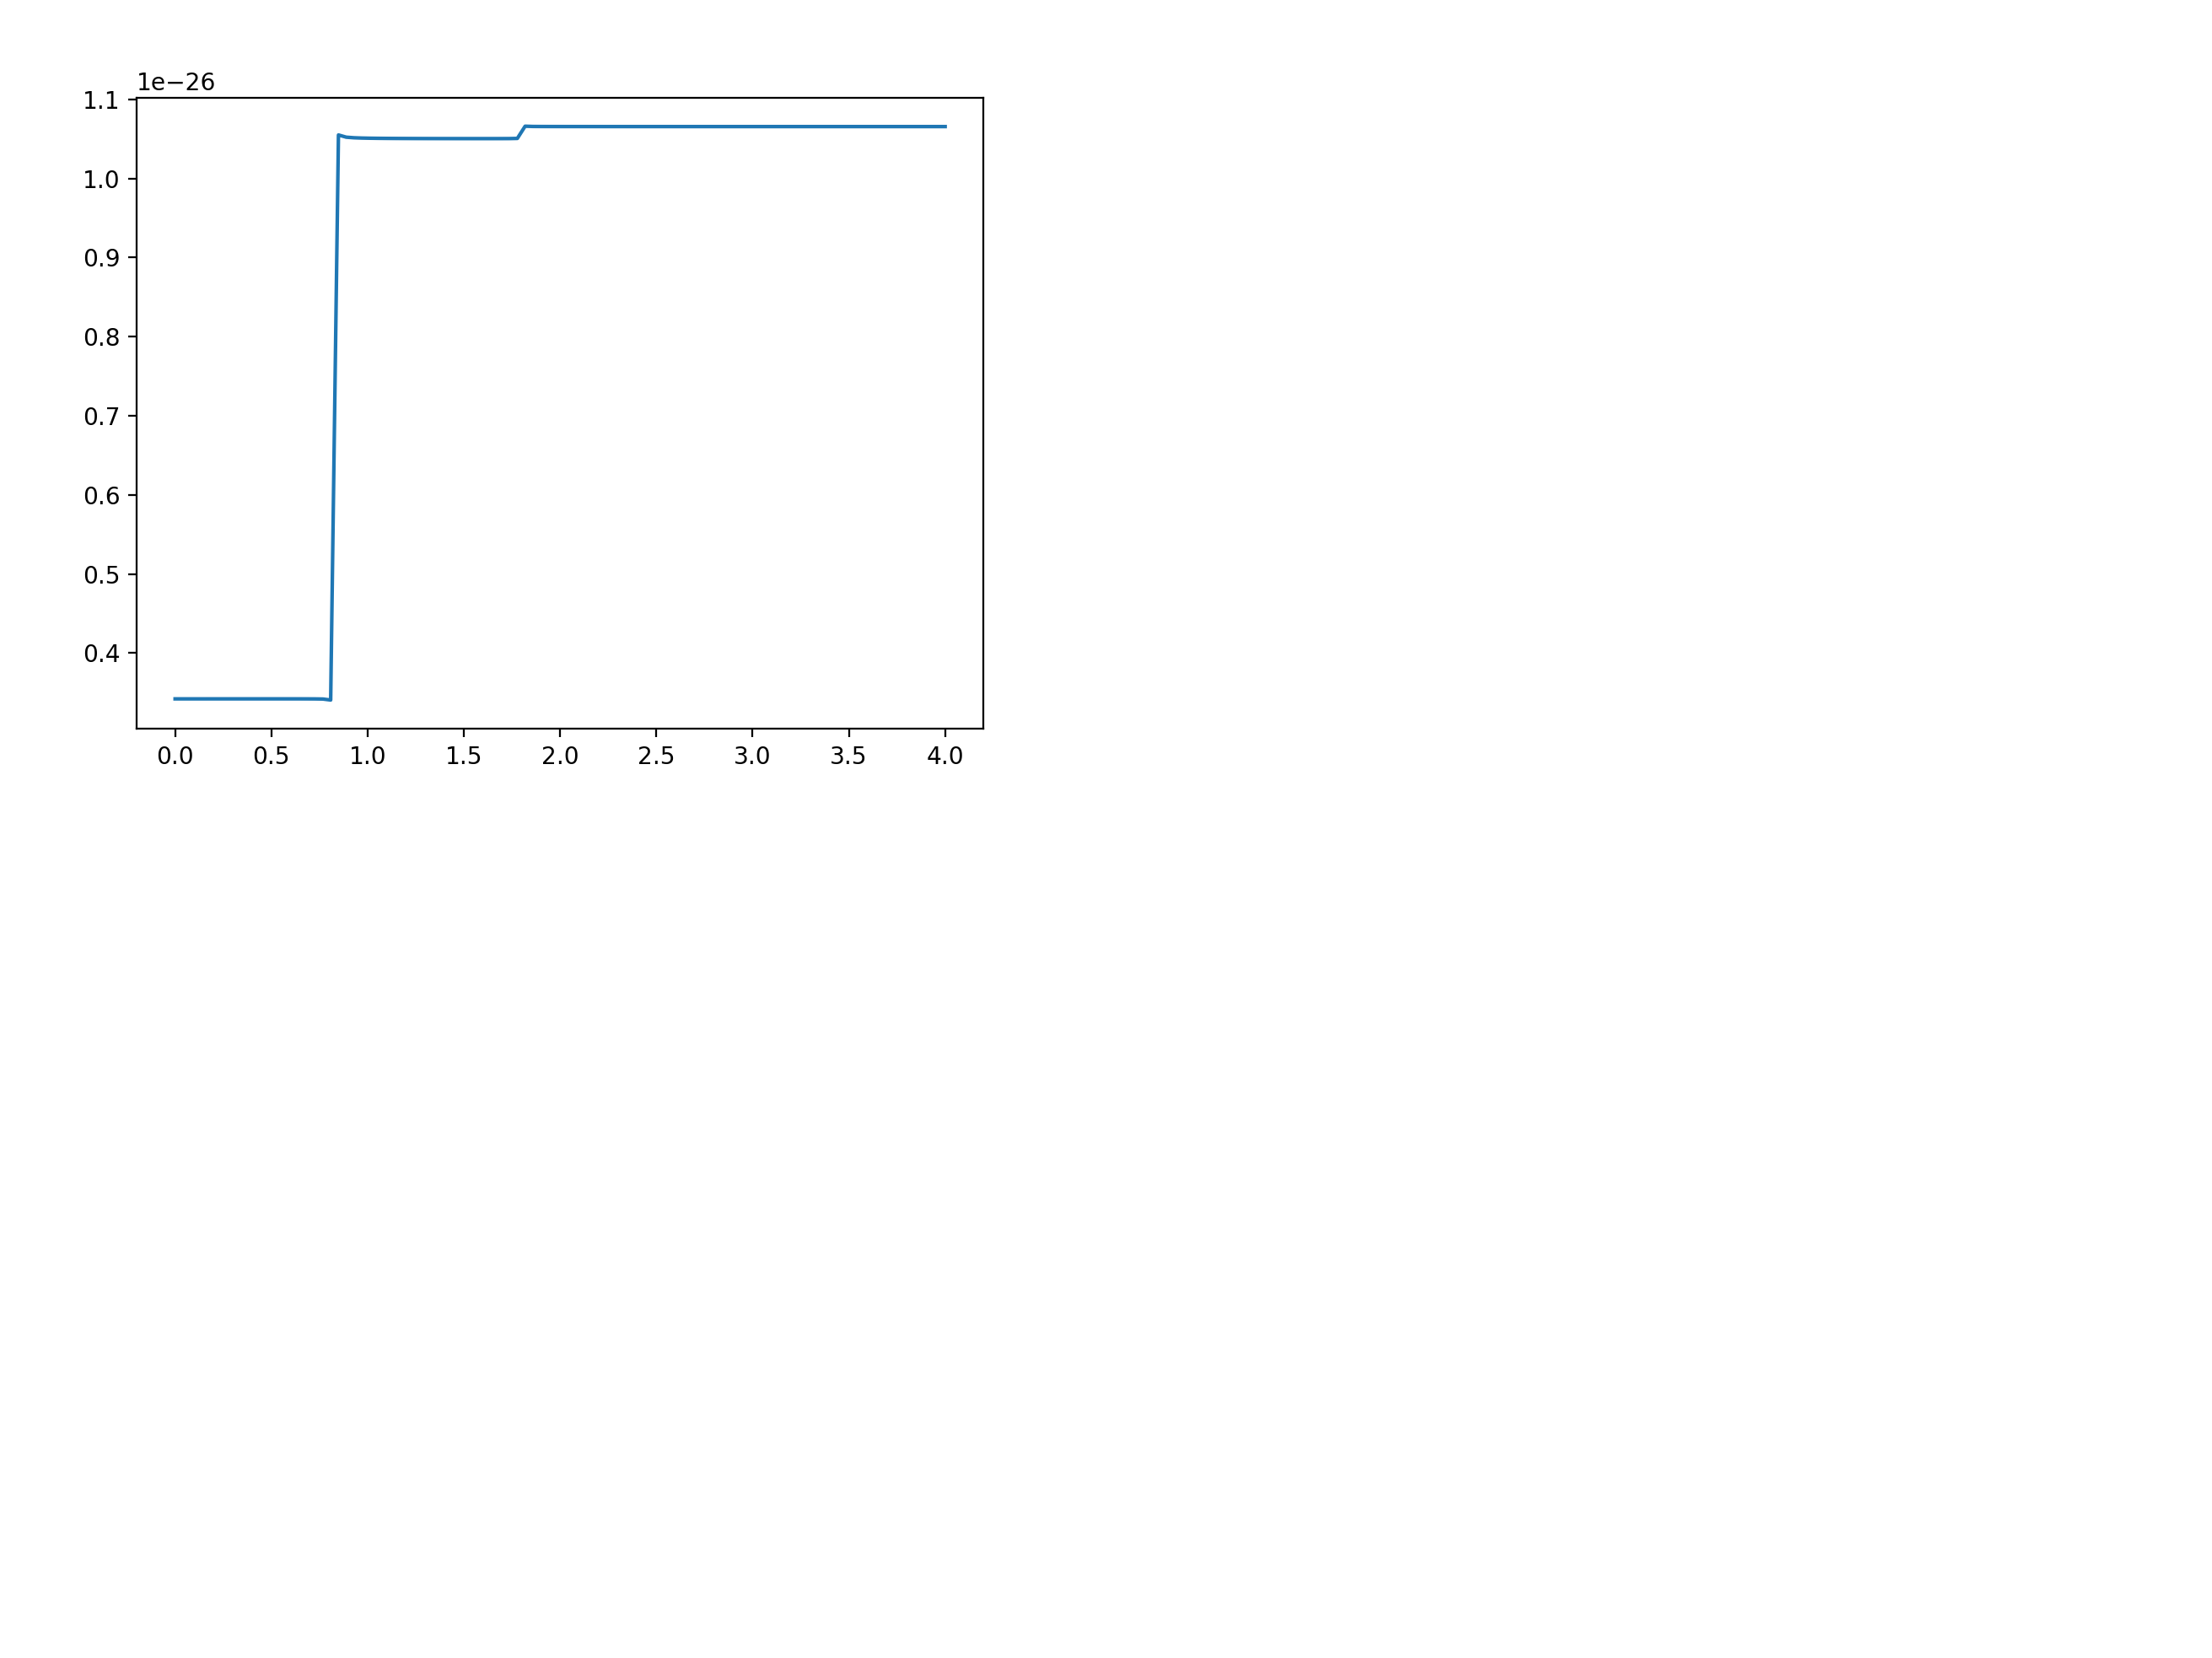

In [150]:
KE_list = [KE(t, sol1) for t in times]
E_list = [Tot_Energy(t, sol1) for t in times]
jup_radii = [np.sqrt((JUP.orbit(JUP.rorbit,JUP.ω, t)[0] -sol1(t)[0])**2+(JUP.orbit(JUP.rorbit,JUP.ω, t)[1]-sol1(t)[2])**2) for t in times]
fig, ax = plt.subplots()
ax.plot(times, E_list); #spike means a fly-by occured

<IPython.core.display.Javascript object>


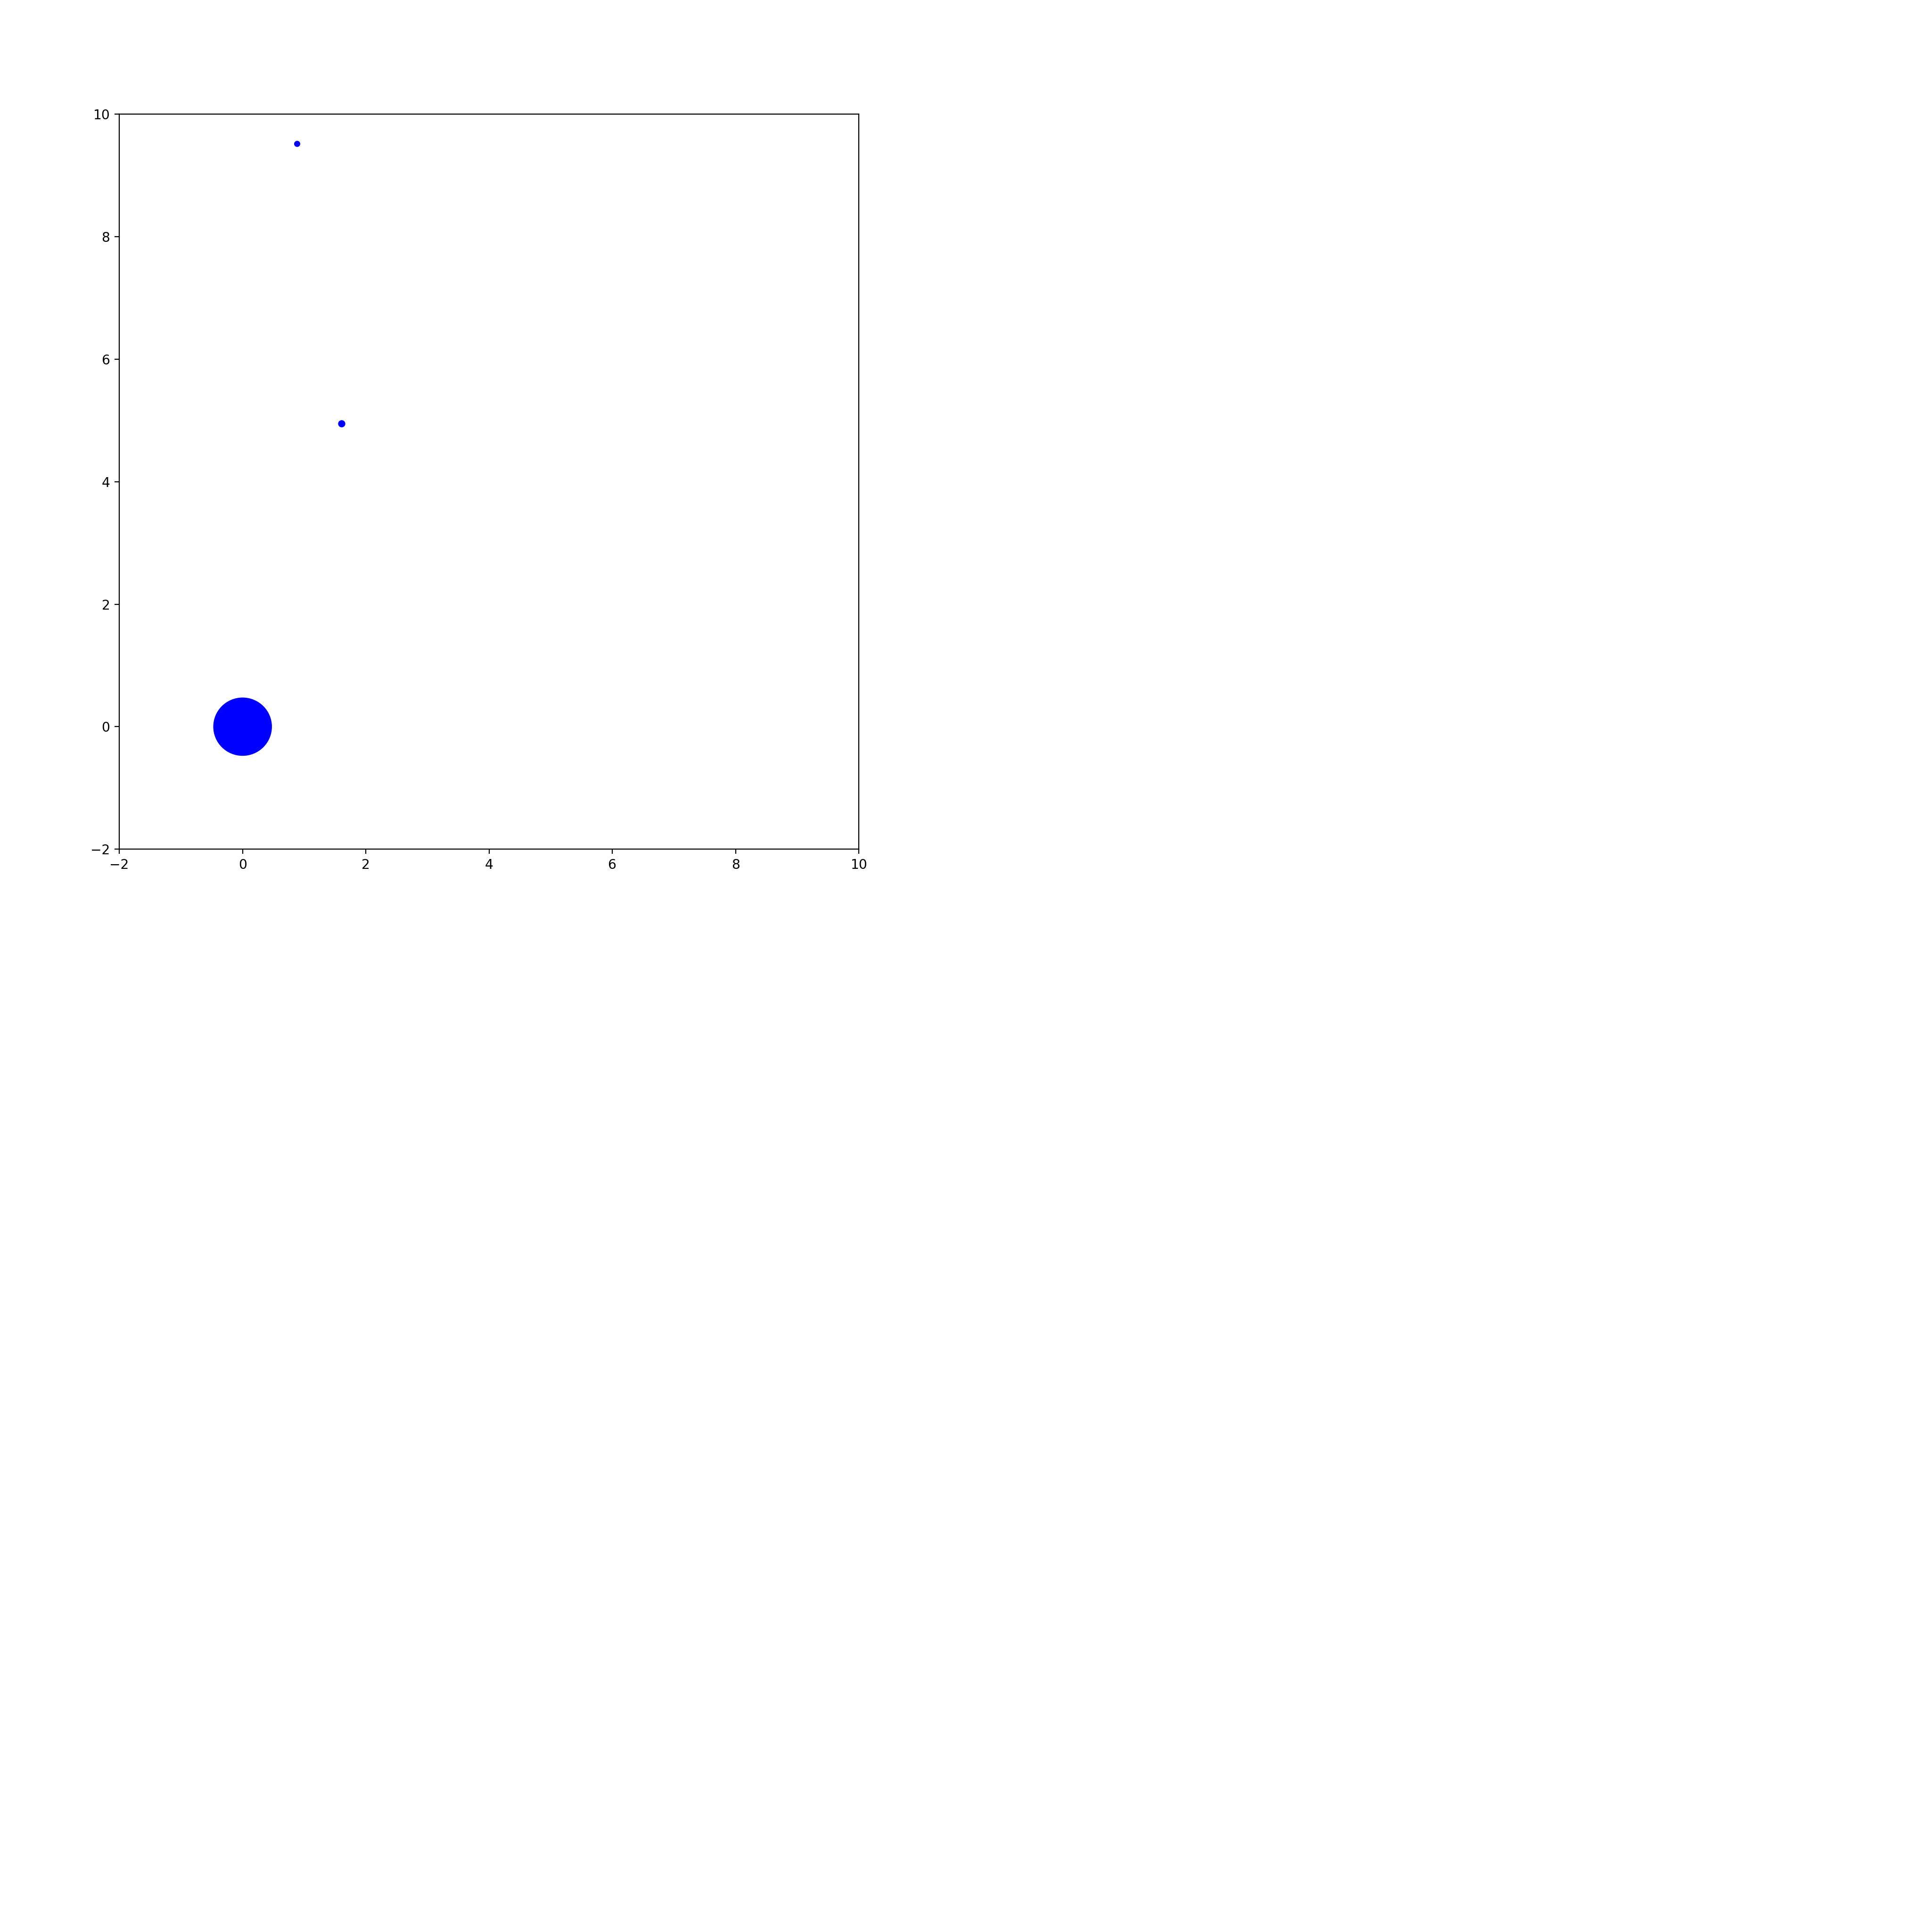

In [151]:
sol1.animate(500);

In [11]:
#### this function is still in the works. The idea is that by looking for big spikes we can find the amount of flybys that 
#### occurred. However, the scale is really hard to work with and spike finding is really difficult to not double count. 
def transfer_number(L, timestep):
    sublists = []
    for i in range(0, len(L), timestep):
        sub = L[i:i+timestep]
        sublists.append(sub)
    
    transfers = 0
    for sublist in sublists:
        if sublist[-1]>sublist[0]+.01*10**(-27):
            transfers += 1
    return transfers

transfer_number(E_list, 100)

1

In [9]:
##outdated but leaving it here for potential inspiration ####


def path_finder(max_vel, max_vel_steps, approach_dist):
    """
    input: max_vel is the maximum total velocity, sol is a solved satellite
    """
    launches = []
    times = np.linspace(0,5,1825)
    count = 0
    give_up_count = 0
    ##### To start we'll pick a date to launch at. since jupiter has a 12 year orbit, we'll allow any day of that orbit for launch #####
    for offset in np.linspace(0,12,1100):
        count += 1
        print(count)
        if give_up_count == 16*max_vel_steps:
            return launches
    ##### next we need to determine the speed we'll launch at #######
        for x_vel in np.linspace(0, max_vel, max_vel_steps):
            y_vel = np.sqrt(max_vel**2 - x_vel**2)
            
    ##### we launch from the earth ###################################
            init_pos = (1,x_vel,0,y_vel)
            sol = Satellite(t_off = offset).solve(init_pos,(0,5))
    ######### make sure we never fall into the sun    ##########
            radii = [np.sqrt(sol(t)[0]**2+sol(t)[2]**2) for t in times]
            if min(radii)>0.004654792558889:
        ##### first we check that the satellite reaches a point where it's reasonably close to Jupiter ####
                jup_radii = [np.sqrt((JUP.orbit(JUP.rorbit,JUP.ω, t,offset)[0] -sol(t)[0])**2+(JUP.orbit(JUP.rorbit,JUP.ω, t,offset)[1]-sol(t)[2])**2) for t in times]
                if min(jup_radii) < approach_dist and min(jup_radii) > 0.0004673296:
                        give_up_count = 0
                        print('succesful approach at offset:', offset, 'x_vel:', x_vel, 'y_vel:',y_vel)

                        ##### now we look for an increase in velocity #############
                        velocities = [np.sqrt(sol(t)[1]**2+sol(t)[3]**2) for t in times]
                        slingshot_velocities = find_increasing_subseq(velocities) #this is extra but whatever
                        if slingshot_velocities[-1] > max_vel:
                            print('succesful launch at offset:', offset, 'x_vel:', x_vel, 'y_vel:',y_vel, 'max vel:', slingshot_velocities[-1])
                            launches.append((offset, x_vel,y_vel, max(velocities)))
    #### if jup
                else:
                    give_up_count += 1
    return launches

L = path_finder(9, 16, 1)

1
succesful approach at offset: 0.0 x_vel: 7.8 y_vel: 4.48998886412873


NameError: name 'find_increasing_subseq' is not defined

In [12]:
def path_finder2():
    """
    input: max_vel is the maximum total velocity, sol is a solved satellite
    """
    launches = []
    times = np.linspace(0,4,100)
    count = 0
    ##### To start we'll pick a date to launch at. since jupiter has a 12 year orbit, we'll allow any day of that orbit for launch #####
    for offset in np.linspace(0,29,10500):
#         count += 1
#         print(count)
    ##### we H.T from the earth ###################################
        init_pos = (0,9.77,-1,0)
        sol = Satellite(t_off = offset, p =[SUN, JUP, SATURN]).solve(init_pos,(0,4))
    ######### make sure we never fall into the sun    ##########
        radii = [np.sqrt(sol(t)[0]**2+sol(t)[2]**2) for t in times]
        if min(radii)>0.004654792558889:
            ### we check how many transfers occured, this doesnt work yet sadly###
            E_list = [Tot_Energy(t, sol) for t in times]
            transfers = transfer_number(E_list, 50)
            print(transfers)
            if transfers == len(sol.planets)-1:
                print('success with offset:', offset)
                launches.append(offset)
                                                            
    return launches

path_finder2()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [143]:
def crash_finder():
    launch_offset = (0,0)
    times = np.linspace(0,4,100)
    count = 0
    ##### To start we'll pick a date to launch at. since jupiter has a 12 year orbit, we'll allow any day of that orbit for launch #####
    for offset in np.linspace(4,5,100):
        count += 1
        print(count)
        SATURN = Planet(m = 0.000285716656, r = 0.000389256877, ro = 9.555, off = offset)
    ##### we H.T from the earth ###################################
        init_pos = (0,9.77,-1,0)
        sol = Satellite(t_off = offset, p =[SUN, JUP, SATURN]).solve(init_pos,(0,4))
    ######### make sure we never fall into the sun    ##########
        E_list = [Tot_Energy(t, sol) for t in times]
        cand_launch = (E_list[-1], offset)
        if cand_launch > launch_offset:
            launch_offset = cand_launch
            print(launch_offset)
    return launch_offset

crash_finder()

1
(1.0500000485296026e-26, 4.0)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(1.0675381207713192e-26, 4.484848484848484)
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


(1.0675381207713192e-26, 4.484848484848484)